In [1]:
import glob, os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
import sklearn
print(sklearn.__version__)
from sklearn.cross_validation import train_test_split  
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score

0.19.1


/home/xnguyen/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/xnguyen/.local/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# read list of vehicles file
cars = []
for directory in glob.glob("data/vehicles/*"):
    cars.extend(glob.glob(directory+"/*"))
len(cars)

8792

In [3]:
notcars = []
for directory in glob.glob("data/non-vehicles/*"):
    notcars.extend(glob.glob(directory+"/*"))
len(notcars)

8968

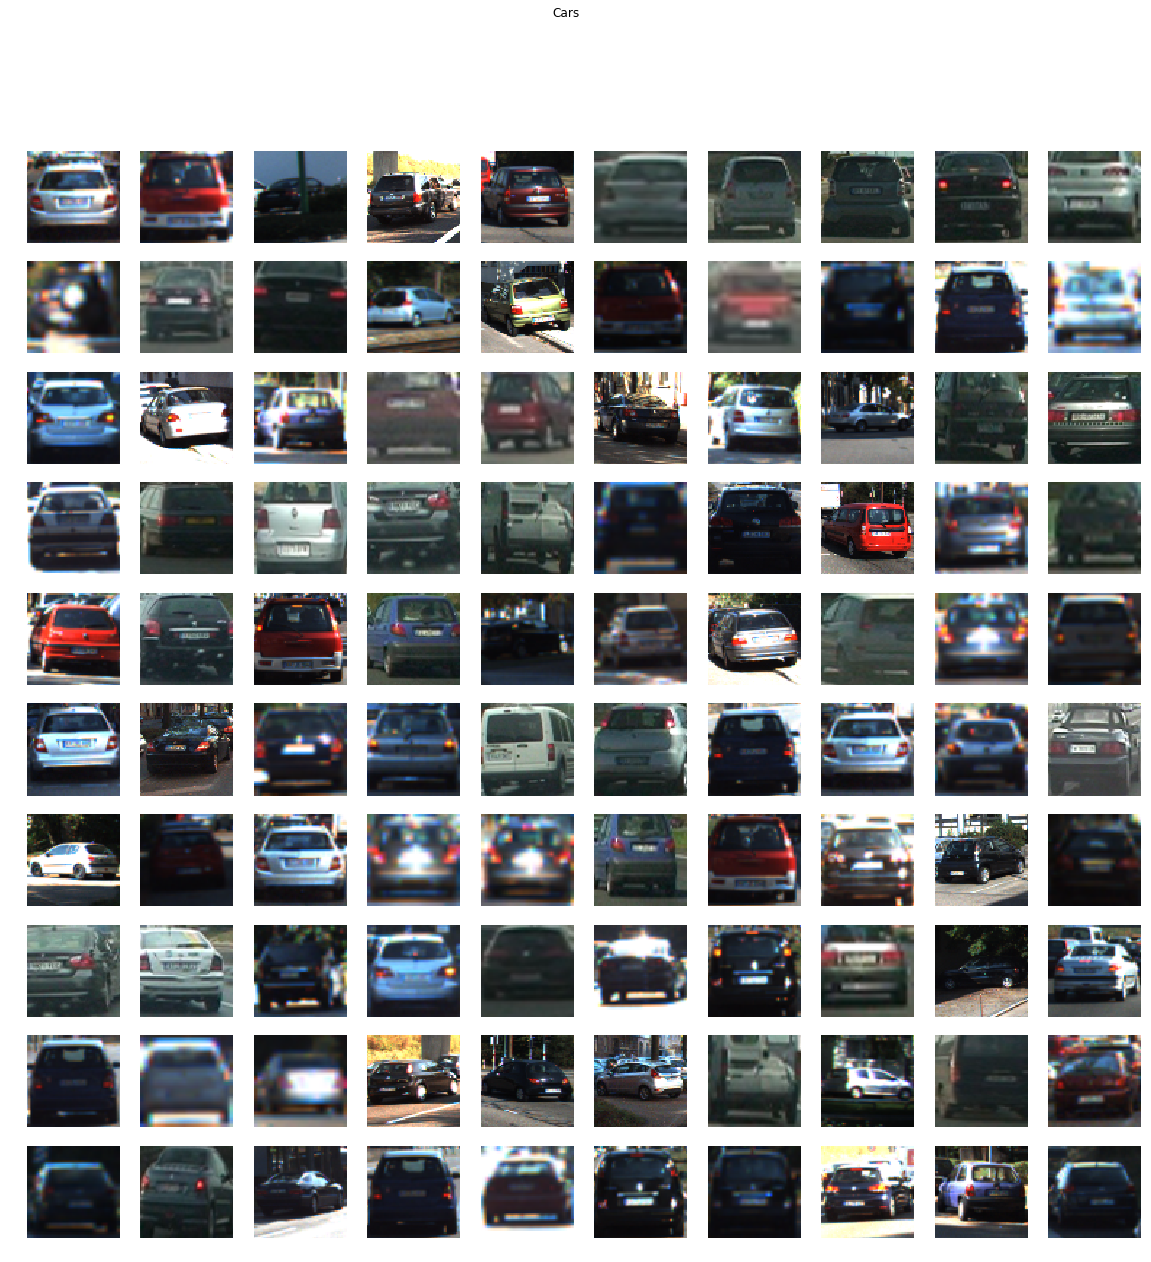

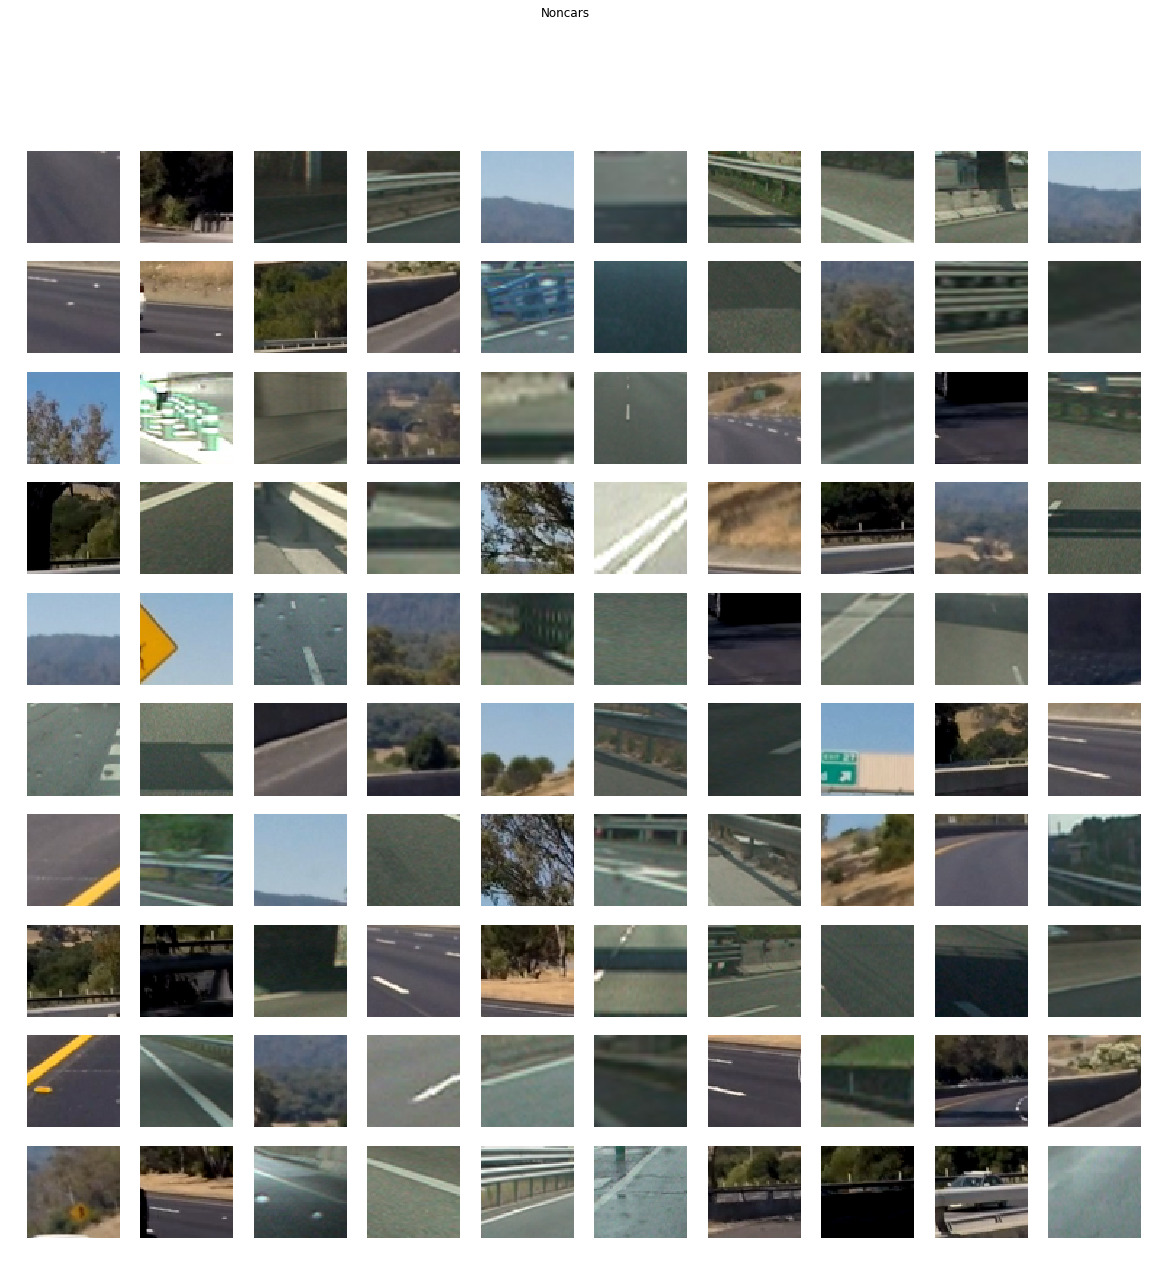

In [4]:
from random import shuffle

shuffle(cars)
shuffle(notcars)

plt.figure(figsize=(20,20))    
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(mpimg.imread(cars[i]))
    plt.axis('off')
plt.suptitle('Cars')
plt.savefig('examples/cars_examples.png')

plt.figure(figsize=(20,20))    
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(mpimg.imread(notcars[i]))
    plt.axis('off')
plt.suptitle('Noncars')    
plt.savefig('examples/noncars_examples.png')
plt.show()


# Extracting HOG features

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

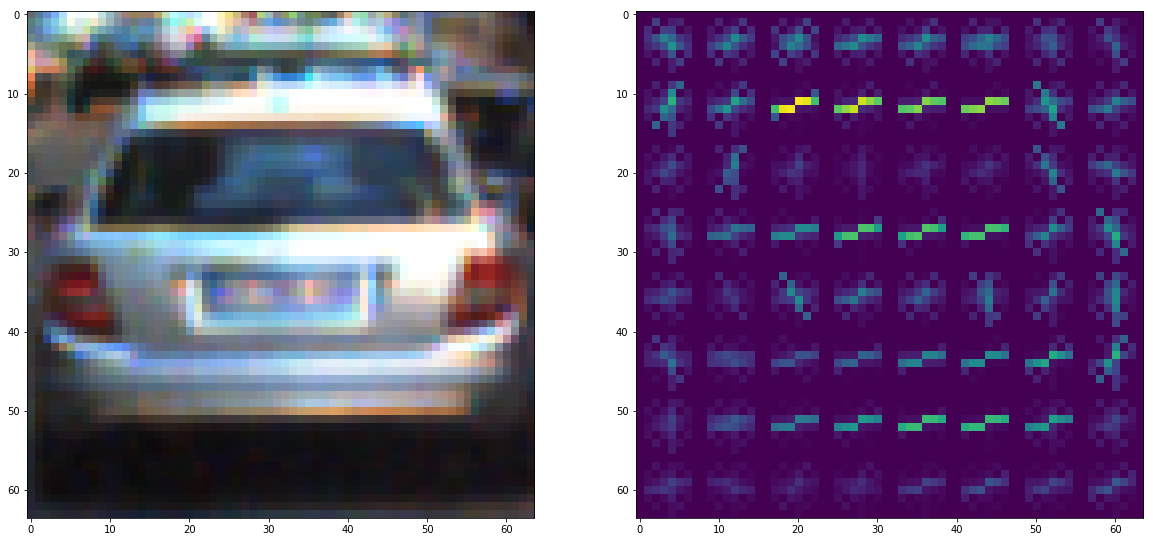

In [6]:
# test HOG visualization
img = mpimg.imread(cars[0])
orient = 9
pix_per_cell = 8
cell_per_block = 2
features, hog_image = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

plt.figure(figsize=(20,20));
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(hog_image)

In [7]:
np.mean(features)

0.9445674981736215

In [8]:
features.shape

(1764,)

In [32]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                     pix_per_cell=8, cell_per_block=2, 
                     hog_channel='ALL',
                     resize=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        if resize: image = cv2.resize(image, (64, 64)) 
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features/np.linalg.norm(hog_features))
    # Return list of feature vectors
    return features

In [10]:
# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
#sample_size = 500 #set sample_size = -1 to include all images
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

In [11]:
len(cars)

8792

In [12]:
### TODO: Tweak these parameters and see how the results change.
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

85.77 Seconds to extract HOG features...


1.0000000000000007
1.0000000000000007


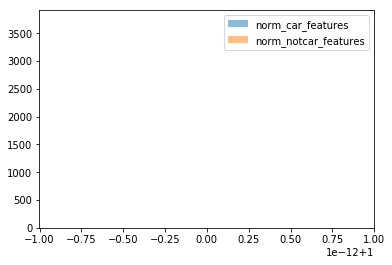

In [13]:
norm_car_features = [np.linalg.norm(x) for x in car_features ]
norm_notcar_features = [np.linalg.norm(x) for x in notcar_features ]

print(np.max(norm_car_features))
print(np.max(norm_notcar_features))

plt.hist(norm_car_features, 50,  alpha=0.5, label='norm_car_features')
plt.hist(norm_notcar_features, 50,  alpha=0.5, label='norm_notcar_features')
plt.legend(loc='upper right')
plt.show()

In [14]:
print(np.mean(norm_car_features))
print(np.mean(norm_notcar_features))

1.0
1.0


In [15]:
import pickle
with open('normalized_features.pickle', 'wb') as handle:
    pickle.dump({'car_features':car_features, 'notcar_features':notcar_features}, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Training classifiers

In [16]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292


In [17]:
X_train.shape

(14208, 5292)

In [18]:
np.linalg.norm(X_train[0])

0.9999999999999997

In [19]:
X_train[0].shape

(5292,)

## Linear SVM

In [21]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

pickle.dump(svc, open("normalized_linearSVM_classifier.pkl", "wb"))

4.37 Seconds to train SVC...
Test Accuracy of SVC =  0.9541
My SVC predicts:  [0. 0. 1. 1. 0. 0. 0. 1. 0. 0.]
For these 10 labels:  [0. 0. 1. 1. 0. 0. 0. 1. 0. 0.]
0.00152 Seconds to predict 10 labels with SVC


5292 1.0000000000000002


array([1.])

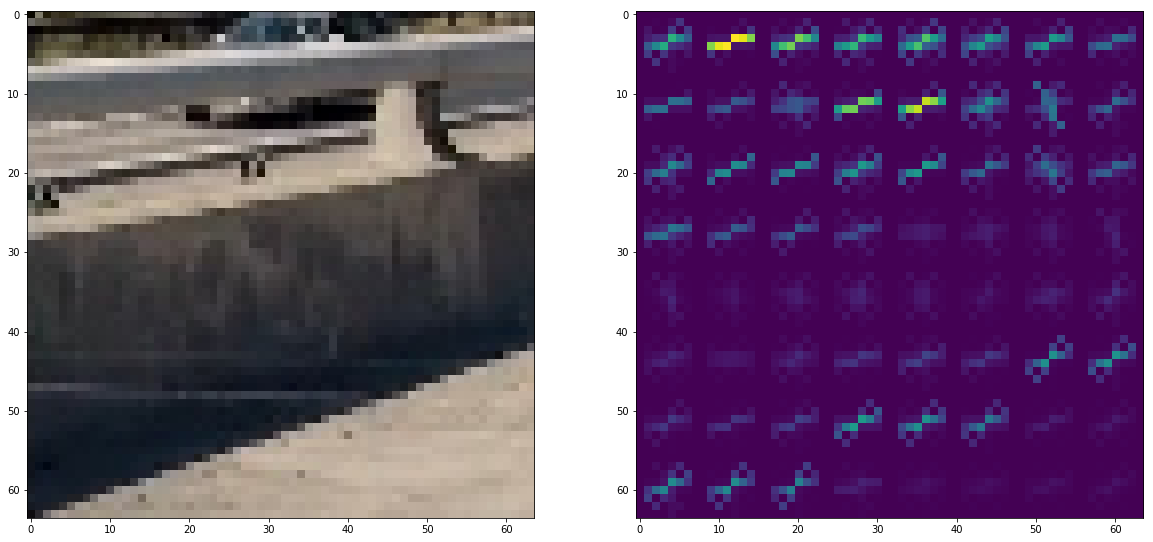

In [37]:
# test HOG visualization
img = cv2.imread('subimg.png')
img = cv2.resize(img, (64, 64)) 

orient = 9
pix_per_cell = 8
cell_per_block = 2

#features, hog_image = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, 
#                        vis=True, feature_vec=True)

features = extract_features(['subimg.png'], cspace='RGB', orient=9, 
                     pix_per_cell=8, cell_per_block=2, 
                     hog_channel='ALL',
                     resize=True)
                 
plt.figure(figsize=(20,20));
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(hog_image)

print(len(features[0]), np.linalg.norm(features))
#test_features = features.reshape(1,-1)/np.linalg.norm(features)
svc.predict(features)

In [ ]:
svc = SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [ ]:
"""
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = SVC()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)
"""

## Xgboost

In [31]:
import xgboost as xgb
# read in data
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


In [32]:
model = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=150,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.75,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True, )


[0]	validation_0-error:0.130771	validation_0-logloss:0.635631	validation_1-error:0.146959	validation_1-logloss:0.637577
[1]	validation_0-error:0.115428	validation_0-logloss:0.586327	validation_1-error:0.132883	validation_1-logloss:0.591111
[2]	validation_0-error:0.09002	validation_0-logloss:0.543735	validation_1-error:0.103041	validation_1-logloss:0.550642
[3]	validation_0-error:0.078055	validation_0-logloss:0.505252	validation_1-error:0.100225	validation_1-logloss:0.514075
[4]	validation_0-error:0.071791	validation_0-logloss:0.471511	validation_1-error:0.090935	validation_1-logloss:0.482854
[5]	validation_0-error:0.067286	validation_0-logloss:0.441493	validation_1-error:0.091498	validation_1-logloss:0.454999
[6]	validation_0-error:0.063345	validation_0-logloss:0.413933	validation_1-error:0.084741	validation_1-logloss:0.428956
[7]	validation_0-error:0.059403	validation_0-logloss:0.389862	validation_1-error:0.083052	validation_1-logloss:0.40648
[8]	validation_0-error:0.057503	validation

[69]	validation_0-error:0.002956	validation_0-logloss:0.044408	validation_1-error:0.031532	validation_1-logloss:0.100729
[70]	validation_0-error:0.002815	validation_0-logloss:0.043244	validation_1-error:0.031813	validation_1-logloss:0.09955
[71]	validation_0-error:0.002463	validation_0-logloss:0.041928	validation_1-error:0.03125	validation_1-logloss:0.09831
[72]	validation_0-error:0.002182	validation_0-logloss:0.040914	validation_1-error:0.030405	validation_1-logloss:0.097189
[73]	validation_0-error:0.002041	validation_0-logloss:0.03992	validation_1-error:0.030968	validation_1-logloss:0.096238
[74]	validation_0-error:0.001971	validation_0-logloss:0.039044	validation_1-error:0.029561	validation_1-logloss:0.09525
[75]	validation_0-error:0.00183	validation_0-logloss:0.038023	validation_1-error:0.029561	validation_1-logloss:0.09422
[76]	validation_0-error:0.001619	validation_0-logloss:0.0371	validation_1-error:0.029842	validation_1-logloss:0.093296
[77]	validation_0-error:0.001619	validati

[139]	validation_0-error:0	validation_0-logloss:0.009581	validation_1-error:0.023086	validation_1-logloss:0.06465
[140]	validation_0-error:0	validation_0-logloss:0.009402	validation_1-error:0.023086	validation_1-logloss:0.064614
[141]	validation_0-error:0	validation_0-logloss:0.009228	validation_1-error:0.023086	validation_1-logloss:0.064386
[142]	validation_0-error:0	validation_0-logloss:0.009061	validation_1-error:0.022523	validation_1-logloss:0.064257
[143]	validation_0-error:0	validation_0-logloss:0.008894	validation_1-error:0.023086	validation_1-logloss:0.064147
[144]	validation_0-error:0	validation_0-logloss:0.008704	validation_1-error:0.022523	validation_1-logloss:0.063959
[145]	validation_0-error:0	validation_0-logloss:0.008542	validation_1-error:0.023086	validation_1-logloss:0.063724
[146]	validation_0-error:0	validation_0-logloss:0.008384	validation_1-error:0.022804	validation_1-logloss:0.06361
[147]	validation_0-error:0	validation_0-logloss:0.008237	validation_1-error:0.0233

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.75, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=8, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [34]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.69%


/home/xnguyen/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [35]:
# save model to file
pickle.dump(model, open("normalized_xgboost_classifier_small.pkl", "wb"))

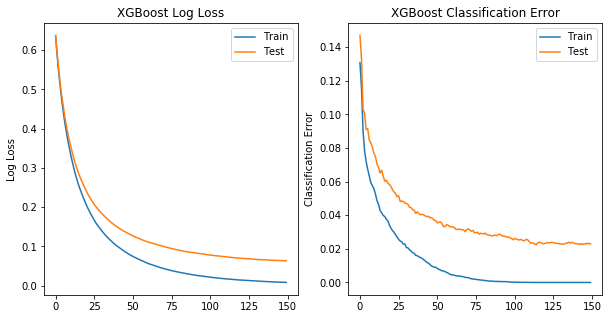

In [36]:
# retrieve performance metrics
def plot_model_learning_curve(model):
    results = model.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)
    # plot log loss
    plt.figure(figsize=(10,5))
    
    ax = plt.subplot(1,2,1)
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    ax.legend()
    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss')

    # plot classification error
    ax = plt.subplot(1,2,2)
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Test')
    ax.legend()
    plt.ylabel('Classification Error')
    plt.title('XGBoost Classification Error')
    plt.show()
plot_model_learning_curve(model)

In [98]:
model2 = xgb.XGBClassifier(
 learning_rate = 0.05,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.5,
 colsample_bytree=0.5,
 objective= 'binary:logistic',
 nthread=12,
 scale_pos_weight=1)
eval_set = [(X_train, y_train), (X_test, y_test)]
model2.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True, )


[0]	validation_0-error:0.19299	validation_0-logloss:0.670123	validation_1-error:0.206363	validation_1-logloss:0.670532
[1]	validation_0-error:0.160051	validation_0-logloss:0.64873	validation_1-error:0.164133	validation_1-logloss:0.649409
[2]	validation_0-error:0.143933	validation_0-logloss:0.628953	validation_1-error:0.158502	validation_1-logloss:0.630349
[3]	validation_0-error:0.135135	validation_0-logloss:0.610017	validation_1-error:0.15259	validation_1-logloss:0.612095
[4]	validation_0-error:0.12859	validation_0-logloss:0.592913	validation_1-error:0.142455	validation_1-logloss:0.595292
[5]	validation_0-error:0.122607	validation_0-logloss:0.57656	validation_1-error:0.132038	validation_1-logloss:0.578808
[6]	validation_0-error:0.114865	validation_0-logloss:0.560819	validation_1-error:0.123311	validation_1-logloss:0.563509
[7]	validation_0-error:0.116273	validation_0-logloss:0.546127	validation_1-error:0.126971	validation_1-logloss:0.549453
[8]	validation_0-error:0.113035	validation_0-

[69]	validation_0-error:0.052154	validation_0-logloss:0.208741	validation_1-error:0.066723	validation_1-logloss:0.22604
[70]	validation_0-error:0.051309	validation_0-logloss:0.206647	validation_1-error:0.065315	validation_1-logloss:0.224326
[71]	validation_0-error:0.051661	validation_0-logloss:0.204888	validation_1-error:0.065878	validation_1-logloss:0.222827
[72]	validation_0-error:0.051239	validation_0-logloss:0.203049	validation_1-error:0.065597	validation_1-logloss:0.221061
[73]	validation_0-error:0.050746	validation_0-logloss:0.201187	validation_1-error:0.064752	validation_1-logloss:0.219292
[74]	validation_0-error:0.050324	validation_0-logloss:0.199125	validation_1-error:0.065597	validation_1-logloss:0.217391
[75]	validation_0-error:0.049831	validation_0-logloss:0.197384	validation_1-error:0.062782	validation_1-logloss:0.215765
[76]	validation_0-error:0.048775	validation_0-logloss:0.195068	validation_1-error:0.062218	validation_1-logloss:0.213349
[77]	validation_0-error:0.049057	

[137]	validation_0-error:0.027872	validation_0-logloss:0.121809	validation_1-error:0.048705	validation_1-logloss:0.146791
[138]	validation_0-error:0.02766	validation_0-logloss:0.121101	validation_1-error:0.049268	validation_1-logloss:0.145986
[139]	validation_0-error:0.027731	validation_0-logloss:0.1205	validation_1-error:0.048423	validation_1-logloss:0.145406
[140]	validation_0-error:0.02752	validation_0-logloss:0.119685	validation_1-error:0.04786	validation_1-logloss:0.144591
[141]	validation_0-error:0.027097	validation_0-logloss:0.118823	validation_1-error:0.047579	validation_1-logloss:0.143616
[142]	validation_0-error:0.027027	validation_0-logloss:0.118007	validation_1-error:0.047579	validation_1-logloss:0.142901
[143]	validation_0-error:0.026886	validation_0-logloss:0.117425	validation_1-error:0.047297	validation_1-logloss:0.142385
[144]	validation_0-error:0.026745	validation_0-logloss:0.116728	validation_1-error:0.046734	validation_1-logloss:0.141795
[145]	validation_0-error:0.02

[205]	validation_0-error:0.015766	validation_0-logloss:0.082386	validation_1-error:0.038007	validation_1-logloss:0.111829
[206]	validation_0-error:0.015555	validation_0-logloss:0.081838	validation_1-error:0.037444	validation_1-logloss:0.111301
[207]	validation_0-error:0.015414	validation_0-logloss:0.081461	validation_1-error:0.037162	validation_1-logloss:0.110949
[208]	validation_0-error:0.015414	validation_0-logloss:0.081083	validation_1-error:0.036881	validation_1-logloss:0.110733
[209]	validation_0-error:0.015555	validation_0-logloss:0.080617	validation_1-error:0.037444	validation_1-logloss:0.110324
[210]	validation_0-error:0.015343	validation_0-logloss:0.080087	validation_1-error:0.036881	validation_1-logloss:0.109829
[211]	validation_0-error:0.015132	validation_0-logloss:0.079685	validation_1-error:0.036599	validation_1-logloss:0.109469
[212]	validation_0-error:0.015132	validation_0-logloss:0.079426	validation_1-error:0.036599	validation_1-logloss:0.109294
[213]	validation_0-error

[273]	validation_0-error:0.00922	validation_0-logloss:0.058736	validation_1-error:0.032658	validation_1-logloss:0.091445
[274]	validation_0-error:0.008868	validation_0-logloss:0.058491	validation_1-error:0.032376	validation_1-logloss:0.091174
[275]	validation_0-error:0.008939	validation_0-logloss:0.058275	validation_1-error:0.032658	validation_1-logloss:0.091002
[276]	validation_0-error:0.008939	validation_0-logloss:0.057998	validation_1-error:0.032658	validation_1-logloss:0.090754
[277]	validation_0-error:0.008868	validation_0-logloss:0.057687	validation_1-error:0.031813	validation_1-logloss:0.090464
[278]	validation_0-error:0.009009	validation_0-logloss:0.05742	validation_1-error:0.032095	validation_1-logloss:0.090207
[279]	validation_0-error:0.008868	validation_0-logloss:0.057182	validation_1-error:0.03125	validation_1-logloss:0.089966
[280]	validation_0-error:0.008657	validation_0-logloss:0.056987	validation_1-error:0.030968	validation_1-logloss:0.08974
[281]	validation_0-error:0.0

[341]	validation_0-error:0.005349	validation_0-logloss:0.042804	validation_1-error:0.025338	validation_1-logloss:0.076893
[342]	validation_0-error:0.005349	validation_0-logloss:0.042699	validation_1-error:0.025338	validation_1-logloss:0.076814
[343]	validation_0-error:0.005279	validation_0-logloss:0.042536	validation_1-error:0.025338	validation_1-logloss:0.076694
[344]	validation_0-error:0.005349	validation_0-logloss:0.042393	validation_1-error:0.024775	validation_1-logloss:0.076518
[345]	validation_0-error:0.005279	validation_0-logloss:0.042212	validation_1-error:0.025056	validation_1-logloss:0.076271
[346]	validation_0-error:0.005208	validation_0-logloss:0.04203	validation_1-error:0.025338	validation_1-logloss:0.075986
[347]	validation_0-error:0.005279	validation_0-logloss:0.041842	validation_1-error:0.025619	validation_1-logloss:0.07584
[348]	validation_0-error:0.005138	validation_0-logloss:0.041639	validation_1-error:0.025056	validation_1-logloss:0.075603
[349]	validation_0-error:0

[409]	validation_0-error:0.002956	validation_0-logloss:0.032241	validation_1-error:0.023649	validation_1-logloss:0.067682
[410]	validation_0-error:0.002956	validation_0-logloss:0.03209	validation_1-error:0.023649	validation_1-logloss:0.067481
[411]	validation_0-error:0.003026	validation_0-logloss:0.031975	validation_1-error:0.023367	validation_1-logloss:0.067397
[412]	validation_0-error:0.003026	validation_0-logloss:0.031887	validation_1-error:0.023649	validation_1-logloss:0.067402
[413]	validation_0-error:0.002886	validation_0-logloss:0.031727	validation_1-error:0.023649	validation_1-logloss:0.067298
[414]	validation_0-error:0.002956	validation_0-logloss:0.031593	validation_1-error:0.023649	validation_1-logloss:0.067133
[415]	validation_0-error:0.002886	validation_0-logloss:0.031451	validation_1-error:0.023649	validation_1-logloss:0.066901
[416]	validation_0-error:0.002886	validation_0-logloss:0.031324	validation_1-error:0.023367	validation_1-logloss:0.066682
[417]	validation_0-error:

[477]	validation_0-error:0.001197	validation_0-logloss:0.024318	validation_1-error:0.020552	validation_1-logloss:0.0604
[478]	validation_0-error:0.001126	validation_0-logloss:0.024214	validation_1-error:0.020552	validation_1-logloss:0.060304
[479]	validation_0-error:0.001126	validation_0-logloss:0.024096	validation_1-error:0.02027	validation_1-logloss:0.060093
[480]	validation_0-error:0.001126	validation_0-logloss:0.023981	validation_1-error:0.019989	validation_1-logloss:0.059946
[481]	validation_0-error:0.001056	validation_0-logloss:0.023862	validation_1-error:0.019989	validation_1-logloss:0.059884
[482]	validation_0-error:0.001056	validation_0-logloss:0.023785	validation_1-error:0.019989	validation_1-logloss:0.059856
[483]	validation_0-error:0.001126	validation_0-logloss:0.023688	validation_1-error:0.019989	validation_1-logloss:0.059779
[484]	validation_0-error:0.001056	validation_0-logloss:0.0236	validation_1-error:0.02027	validation_1-logloss:0.059691
[485]	validation_0-error:0.001

[545]	validation_0-error:0.000493	validation_0-logloss:0.018734	validation_1-error:0.0183	validation_1-logloss:0.05505
[546]	validation_0-error:0.000422	validation_0-logloss:0.018692	validation_1-error:0.0183	validation_1-logloss:0.05504
[547]	validation_0-error:0.000422	validation_0-logloss:0.018622	validation_1-error:0.018581	validation_1-logloss:0.054959
[548]	validation_0-error:0.000422	validation_0-logloss:0.018546	validation_1-error:0.018581	validation_1-logloss:0.054829
[549]	validation_0-error:0.000422	validation_0-logloss:0.018501	validation_1-error:0.018863	validation_1-logloss:0.054834
[550]	validation_0-error:0.000422	validation_0-logloss:0.018417	validation_1-error:0.018863	validation_1-logloss:0.054752
[551]	validation_0-error:0.000422	validation_0-logloss:0.018315	validation_1-error:0.018581	validation_1-logloss:0.054641
[552]	validation_0-error:0.000422	validation_0-logloss:0.018255	validation_1-error:0.0183	validation_1-logloss:0.054532
[553]	validation_0-error:0.00042

[613]	validation_0-error:0.000141	validation_0-logloss:0.014598	validation_1-error:0.017736	validation_1-logloss:0.050816
[614]	validation_0-error:0.000141	validation_0-logloss:0.014552	validation_1-error:0.018018	validation_1-logloss:0.050721
[615]	validation_0-error:0.000141	validation_0-logloss:0.014496	validation_1-error:0.018018	validation_1-logloss:0.050716
[616]	validation_0-error:0.000141	validation_0-logloss:0.014444	validation_1-error:0.017736	validation_1-logloss:0.05067
[617]	validation_0-error:0.000141	validation_0-logloss:0.01438	validation_1-error:0.018018	validation_1-logloss:0.050605
[618]	validation_0-error:0.000141	validation_0-logloss:0.014327	validation_1-error:0.017736	validation_1-logloss:0.050462
[619]	validation_0-error:0.000141	validation_0-logloss:0.014284	validation_1-error:0.0183	validation_1-logloss:0.050383
[620]	validation_0-error:0.000141	validation_0-logloss:0.014215	validation_1-error:0.0183	validation_1-logloss:0.050276
[621]	validation_0-error:0.000

[681]	validation_0-error:0.000141	validation_0-logloss:0.011422	validation_1-error:0.01661	validation_1-logloss:0.048093
[682]	validation_0-error:0.000141	validation_0-logloss:0.011392	validation_1-error:0.01661	validation_1-logloss:0.048022
[683]	validation_0-error:0.000141	validation_0-logloss:0.011351	validation_1-error:0.01661	validation_1-logloss:0.047993
[684]	validation_0-error:0.000141	validation_0-logloss:0.011305	validation_1-error:0.016329	validation_1-logloss:0.047918
[685]	validation_0-error:0.000141	validation_0-logloss:0.011271	validation_1-error:0.01661	validation_1-logloss:0.047912
[686]	validation_0-error:0.000141	validation_0-logloss:0.011221	validation_1-error:0.016329	validation_1-logloss:0.047832
[687]	validation_0-error:0.000141	validation_0-logloss:0.011169	validation_1-error:0.01661	validation_1-logloss:0.047777
[688]	validation_0-error:0.000141	validation_0-logloss:0.011127	validation_1-error:0.016892	validation_1-logloss:0.047742
[689]	validation_0-error:0.00

[749]	validation_0-error:7e-05	validation_0-logloss:0.008993	validation_1-error:0.016329	validation_1-logloss:0.04557
[750]	validation_0-error:7e-05	validation_0-logloss:0.008958	validation_1-error:0.016329	validation_1-logloss:0.045498
[751]	validation_0-error:7e-05	validation_0-logloss:0.008926	validation_1-error:0.016047	validation_1-logloss:0.045496
[752]	validation_0-error:7e-05	validation_0-logloss:0.008892	validation_1-error:0.016047	validation_1-logloss:0.045438
[753]	validation_0-error:7e-05	validation_0-logloss:0.008851	validation_1-error:0.016047	validation_1-logloss:0.045322
[754]	validation_0-error:7e-05	validation_0-logloss:0.008821	validation_1-error:0.015766	validation_1-logloss:0.045233
[755]	validation_0-error:7e-05	validation_0-logloss:0.008796	validation_1-error:0.015766	validation_1-logloss:0.045197
[756]	validation_0-error:7e-05	validation_0-logloss:0.008771	validation_1-error:0.015766	validation_1-logloss:0.045191
[757]	validation_0-error:7e-05	validation_0-loglo

[819]	validation_0-error:7e-05	validation_0-logloss:0.007072	validation_1-error:0.015484	validation_1-logloss:0.043203
[820]	validation_0-error:7e-05	validation_0-logloss:0.007049	validation_1-error:0.015766	validation_1-logloss:0.043164
[821]	validation_0-error:7e-05	validation_0-logloss:0.00702	validation_1-error:0.015484	validation_1-logloss:0.043114
[822]	validation_0-error:7e-05	validation_0-logloss:0.006996	validation_1-error:0.015766	validation_1-logloss:0.04304
[823]	validation_0-error:7e-05	validation_0-logloss:0.006969	validation_1-error:0.015484	validation_1-logloss:0.042985
[824]	validation_0-error:7e-05	validation_0-logloss:0.006948	validation_1-error:0.015766	validation_1-logloss:0.042999
[825]	validation_0-error:0	validation_0-logloss:0.006927	validation_1-error:0.015766	validation_1-logloss:0.042961
[826]	validation_0-error:0	validation_0-logloss:0.006898	validation_1-error:0.015484	validation_1-logloss:0.042951
[827]	validation_0-error:0	validation_0-logloss:0.00688	va

[891]	validation_0-error:0	validation_0-logloss:0.005594	validation_1-error:0.015484	validation_1-logloss:0.041496
[892]	validation_0-error:0	validation_0-logloss:0.005576	validation_1-error:0.015484	validation_1-logloss:0.041477
[893]	validation_0-error:0	validation_0-logloss:0.005563	validation_1-error:0.015484	validation_1-logloss:0.041433
[894]	validation_0-error:0	validation_0-logloss:0.005544	validation_1-error:0.015484	validation_1-logloss:0.041407
[895]	validation_0-error:0	validation_0-logloss:0.005524	validation_1-error:0.015484	validation_1-logloss:0.041418
[896]	validation_0-error:0	validation_0-logloss:0.005508	validation_1-error:0.015484	validation_1-logloss:0.041433
[897]	validation_0-error:0	validation_0-logloss:0.005492	validation_1-error:0.015484	validation_1-logloss:0.041438
[898]	validation_0-error:0	validation_0-logloss:0.005477	validation_1-error:0.015484	validation_1-logloss:0.041424
[899]	validation_0-error:0	validation_0-logloss:0.005464	validation_1-error:0.01

[963]	validation_0-error:0	validation_0-logloss:0.004508	validation_1-error:0.015203	validation_1-logloss:0.040312
[964]	validation_0-error:0	validation_0-logloss:0.004494	validation_1-error:0.015203	validation_1-logloss:0.040279
[965]	validation_0-error:0	validation_0-logloss:0.004482	validation_1-error:0.015203	validation_1-logloss:0.040207
[966]	validation_0-error:0	validation_0-logloss:0.004465	validation_1-error:0.01464	validation_1-logloss:0.040167
[967]	validation_0-error:0	validation_0-logloss:0.004453	validation_1-error:0.015203	validation_1-logloss:0.040152
[968]	validation_0-error:0	validation_0-logloss:0.004438	validation_1-error:0.015203	validation_1-logloss:0.040171
[969]	validation_0-error:0	validation_0-logloss:0.004427	validation_1-error:0.014921	validation_1-logloss:0.040134
[970]	validation_0-error:0	validation_0-logloss:0.004413	validation_1-error:0.015203	validation_1-logloss:0.040144
[971]	validation_0-error:0	validation_0-logloss:0.0044	validation_1-error:0.01492

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=12, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)

/home/xnguyen/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 98.54%


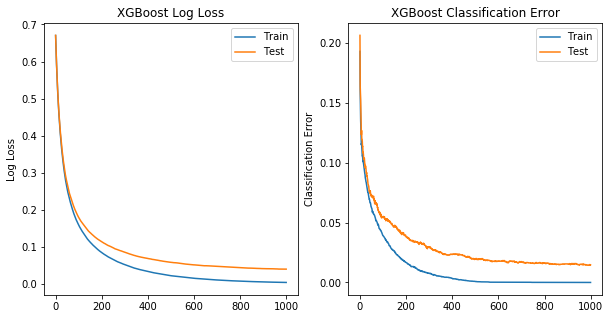

In [99]:
# make predictions for test data
y_pred = model2.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
plot_model_learning_curve(model2)

In [103]:
# save model to file
pickle.dump((model2, X_scaler), open("xgboost_classifier.pkl", "wb"))

In [104]:
# load model from file
loaded_model, X_scaler = pickle.load(open("xgboost_classifier.pkl", "rb"))

/home/xnguyen/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 98.54%


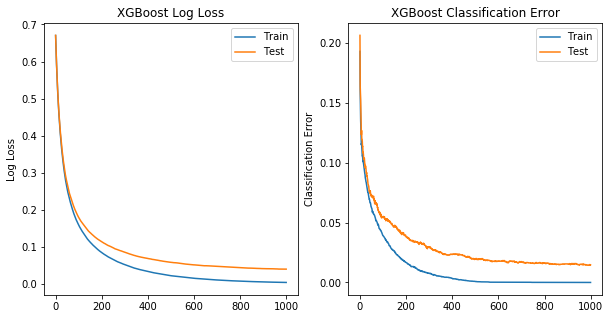

In [105]:
# make predictions for test data
y_pred = loaded_model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
plot_model_learning_curve(model2)

In [106]:
X_scaler

StandardScaler(copy=True, with_mean=True, with_std=True)